In [94]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

model = ResNet50(weights='imagenet')

In [88]:
def Hbeta(D = np.array([]), beta = 1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X = np.array([]), tol = 1e-5, perplexity = 30.0):
    """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point ", i, " of ", n, "...")

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax =  np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries = tries + 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: ", np.mean(np.sqrt(1 / beta)))
    return P


def pca(X = np.array([]), no_dims = 50):
    """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:,0:no_dims])
    return Y


def tsne(X = np.array([]), no_dims = 2, initial_dims = 50, perplexity = 30.0):
    """Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4;                                    # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = 1 / (1 + np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i,:] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration ", (iter + 1), ": error is ", C)

        # Stop lying about P-values
        if iter == 100:
            P = P / 4

    # Return solution
    return Y


In [52]:
img_url = 'http://www.stsci.edu/~jegpeek/images/eyes.jpg'
#img_url = 'https://archive.stsci.edu/archive_news/images/avatar_hargis.jpg'
# ckj img_url = 'https://lh3.googleusercontent.com/kHABpnUYh5L0yMqpWlmk5TbBpp_zqNYrYuo1pXlW4jluve7NHWhaahVRMZUOqQZjzhyLmBCRuVFrEJcvuU1p4fcGa12ONSU9eMasS9B0b8BFDYvLgxuDptbAIKFDPux9WrcHj7cM81Q=w1037-h1263-no'
# jgj img_url = 'https://lh3.googleusercontent.com/E-4waTB8MHif8qsBte9fKYSZBbWy7-yn_ltFQVVa533Q1GdFpKt-T8nejVQ_tTf1l7OJUbBxRYNV2fzrPxaLr04PIE-l7ArKEiV2MVxxqzWdjig1GdpvFkIZd43G3X7F-k3ulPpLLRc=w1300-h1432-no'
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img = img.resize((224,224))
img = img.convert('RGB')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
predictions = decode_predictions(preds, top=3)[0]
print('\nPredicted:')
for x in predictions:
    print(x)

(1, 224, 224, 3)

Predicted:
('n02883205', 'bow_tie', 0.12963434)
('n02992529', 'cellular_telephone', 0.083071351)
('n04591157', 'Windsor_tie', 0.045396786)


In [53]:
carina = np.load('/Users/crjones/Documents/Science/HargisDDRF/carina_299.npy')

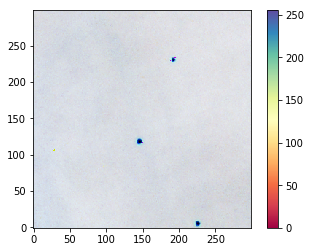

In [54]:
plt.imshow(carina[:,:,:,10])
plt.colorbar()
plt.show()

In [55]:
def histeq(im,nbr_bins=256):
  """  Histogram equalization of a grayscale image. """

  # get image histogram
  imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
  cdf = imhist.cumsum() # cumulative distribution function
  cdf = 255 * cdf / cdf[-1] # normalize

  # use linear interpolation of cdf to find new pixel values
  im2 = np.interp(im.flatten(),bins[:-1],cdf)

  return im2.reshape(im.shape)

#if False:
#    carina[:,:,:,0] = histeq(carina[:,:,:,0])
#else:
#    carina[:,:,:,0] = np.log(carina[:,:,:,0]+1)

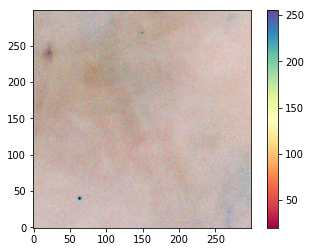

In [56]:
plt.imshow(carina[:,:,:,0])
plt.colorbar()
plt.show()

In [57]:
x = carina[0:224,0:224,:,1]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(x.shape)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
predictions = decode_predictions(preds, top=3)[0]
print('\nPredicted:')
for x in predictions:
    print(x)

(1, 224, 224, 3)

Predicted:
('n01498041', 'stingray', 0.22790781)
('n02111277', 'Newfoundland', 0.042395636)
('n02536864', 'coho', 0.040477723)


In [107]:
first, second, third = [], [], []
high = {}

labels = []
all = {}

for ii in range(88):
    x = carina[0:224,0:224,:,ii]
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    predictions = decode_predictions(preds, top=10)[0]
    
    # Get the name of the first, second and third for each
    first.append(predictions[0][1])
    second.append(predictions[1][1])
    third.append(predictions[2][1])
    
    all[ii] = []
    for x in predictions:
        if x[1] in high:
            high[x[1]] = high[x[1]] + x[2]
        else:
            high[x[1]] = x[2]
         
        all[ii].append([x[1], x[2]])
 

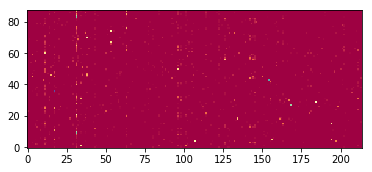

In [123]:
# Reformat the all information
labels = list(set([x[0] for k, y in all.items() for x in y ]))
X = np.zeros((88, len(labels)))
for ii in range(88):
    for jj in all[ii]:
        X[ii,labels.index(jj[0])] = jj[1]
plt.imshow(X)

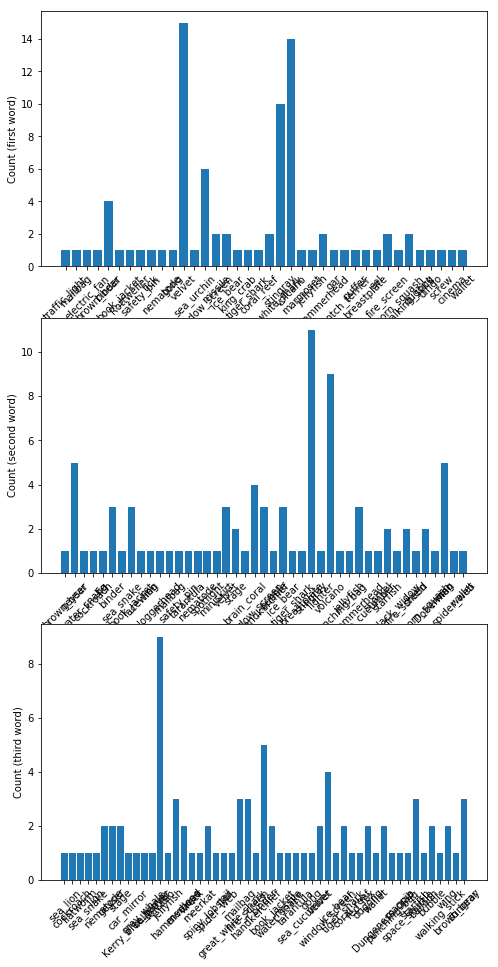

In [59]:
import matplotlib.pyplot as plt

def show_words(words):
    word_counts = Counter(words)
    plt.bar(range(len(word_counts)), word_counts.values(), align='center')
    plt.xticks(range(len(word_counts)), word_counts.keys(), rotation=45)
    
plt.figure(figsize=[8,16])    
plt.subplot(3,1,1)
show_words(first)
plt.ylabel('Count (first word)')

plt.subplot(3,1,2)
show_words(second)
plt.ylabel('Count (second word)')

plt.subplot(3,1,3)
show_words(third)
plt.ylabel('Count (third word)')

plt.show()

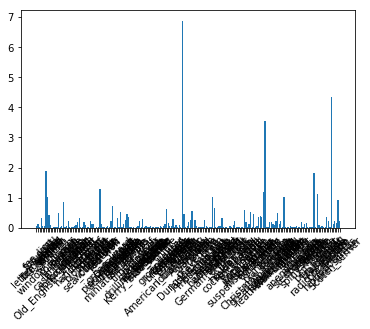

In [60]:
plt.bar(range(len(high)), high.values(), align='center')
plt.xticks(range(len(high)), high.keys(), rotation=45)
plt.show()

In [61]:
sorted(high.items(), key=lambda x: x[1], reverse=True)

[('volcano', 6.8786602),
 ('velvet', 4.3521619),
 ('stingray', 3.5557544),
 ('window_screen', 1.8803679),
 ('binder', 1.8271954),
 ('ice_bear', 1.2732995),
 ('great_white_shark', 1.1859928),
 ('missile', 1.1346111),
 ('hammerhead', 1.0281096),
 ('geyser', 1.0190006),
 ('wing', 1.0037189),
 ('fire_screen', 0.92535454),
 ('jellyfish', 0.85719818),
 ('acorn_squash', 0.71816939),
 ('nematode', 0.64693087),
 ('brown_bear', 0.63268512),
 ('book_jacket', 0.60285652),
 ('snorkel', 0.55772549),
 ('traffic_light', 0.51987064),
 ('gong', 0.51306283),
 ('coral_reef', 0.49341178),
 ('starfish', 0.48095232),
 ('mailbag', 0.45213917),
 ('dugong', 0.44635138),
 ('sea_urchin', 0.44567937),
 ('stage', 0.42329228),
 ('tiger_shark', 0.38438618),
 ('safety_pin', 0.37102178),
 ('king_crab', 0.36594775),
 ('wallet', 0.36471075),
 ('puffer', 0.34261858),
 ('marmoset', 0.33250841),
 ('loggerhead', 0.31981048),
 ('coho', 0.31779137),
 ('handkerchief', 0.3144604),
 ('tarantula', 0.29952034),
 ('electric_ray', 0.

In [62]:
high

{'American_black_bear': 0.042424358,
 'Arctic_fox': 0.059421722,
 'Band_Aid': 0.010602723,
 'Cardigan': 0.024799522,
 'Christmas_stocking': 0.043910105,
 'Doberman': 0.039830856,
 'Dungeness_crab': 0.18512157,
 'German_shepherd': 0.024232425,
 'Kerry_blue_terrier': 0.049441263,
 'Old_English_sheepdog': 0.020536607,
 'Rottweiler': 0.060053986,
 'Scotch_terrier': 0.20709082,
 'acorn_squash': 0.71816939,
 'airliner': 0.0055128364,
 'airship': 0.031471718,
 'anemone_fish': 0.017398149,
 'ant': 0.017823825,
 'axolotl': 0.036744315,
 'baboon': 0.020754192,
 'balloon': 0.14384066,
 'ballplayer': 0.037642322,
 'beacon': 0.0097903516,
 'bell_pepper': 0.013221289,
 'binder': 1.8271954,
 'black_widow': 0.1266014,
 'bloodhound': 0.030288786,
 'book_jacket': 0.60285652,
 'brain_coral': 0.067293189,
 'breastplate': 0.20791295,
 'brown_bear': 0.63268512,
 'bubble': 0.25463542,
 'cannon': 0.02943244,
 'car_mirror': 0.057101119,
 'cardigan': 0.017215729,
 'cash_machine': 0.017663298,
 'chime': 0.108493

In [124]:
Y = tsne(X, 2)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  88 ...
Mean value of sigma:  0.140399342482
Iteration  10 : error is  12.9830838585
Iteration  20 : error is  12.2056543776
Iteration  30 : error is  13.2951841262
Iteration  40 : error is  12.9063186635
Iteration  50 : error is  13.2947385896
Iteration  60 : error is  13.3679911147
Iteration  70 : error is  13.9306126806
Iteration  80 : error is  12.845309054
Iteration  90 : error is  13.5414073672
Iteration  100 : error is  14.147372609
Iteration  110 : error is  1.55937111464
Iteration  120 : error is  1.38911896908
Iteration  130 : error is  1.22098219086
Iteration  140 : error is  1.07397068003
Iteration  150 : error is  0.873282659552
Iteration  160 : error is  0.757738072934
Iteration  170 : error is  0.667575808453
Iteration  180 : error is  0.590809720636
Iteration  190 : error is  0.533773130941
Iteration  200 : error is  0.490619449093
Iteration  210 : error is  0.4568009

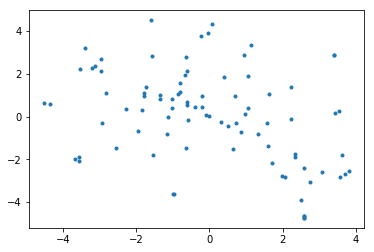

In [125]:
plt.plot(Y[:,0], Y[:,1], '.')

In [ ]:
l